In [1]:
# sqlalchemy-challenge
# Ignore SQLITE warnings related to Decimal numbers in the database
import warnings
warnings.filterwarnings('ignore')

# Import Dependencies
import numpy as np
import pandas as pd
import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import func


%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

# Create an engine for the chinook.sqlite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [2]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Design a query to retrieve the last 12 months of precipitation data and plot the results
#session.query(Measurement.prcp, func.avg(Measurement.prcp)).order_by(func.date(Measurement.date).desc()).all()
    #group_by(Measurement.station).\

# ar = annual rain
ar = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
ar = ar[0]
print(ar)

2017-08-23


In [3]:
# Calculate the date 1 year ago from the last data point in the database
# ly = last_year
ly = dt.datetime.strptime(ar, "%Y-%m-%d") - dt.timedelta(days=365)
print(ly)

2016-08-23 00:00:00


In [4]:
# Perform a query to retrieve the data and precipitation scores
q = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= ly).all()
#print(q)

In [5]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(q,columns=['date', 'precipitation'])
prcp_df.set_index('date', inplace=True)
prcp_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [6]:
# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by='date',ascending=True)
prcp_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


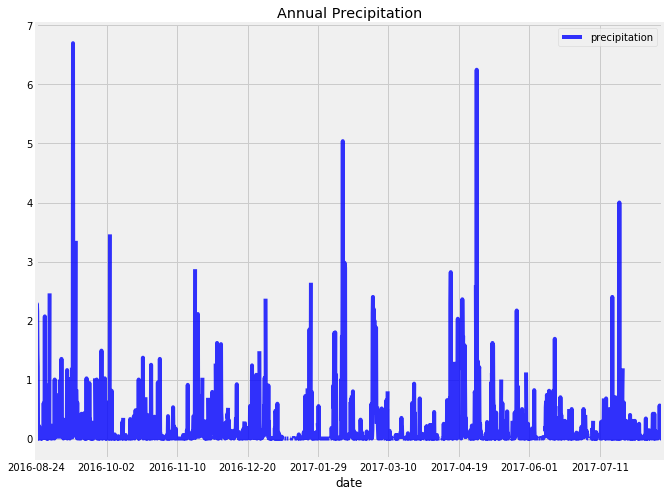

In [7]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Annual Precipitation", color='blue', alpha=0.8, figsize=(10,8))
plt.legend(loc='upper right', prop={'size': 10})
plt.savefig("annual_prcp.png")
plt.show()

In [8]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [9]:
# STATION ANALYSIS
# Design a query to show how many stations are available in this dataset?
# s = stations
#s = session.query(Measurement.station).count.unique()

qu = session.query(Measurement.station, Measurement.date).filter(Measurement.date >= ly).all()
s_df = pd.DataFrame(qu,columns=['station','date'])
#s_df.head()

#s = s_df.value_counts(dropna=False)
#print(s)

s = s_df['station'].nunique()
print(s)

7


In [10]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
acts = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(acts)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [11]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
acts_basics = acts
acts_basics = session.query(func.min(Measurement.tobs), 
                            func.max(Measurement.tobs),
                            func.avg(Measurement.tobs)).all()

# Print results
print(acts_basics)

[(53.0, 87.0, 73.09795396419437)]


In [12]:
# Basic stats of the most active station?
# First, find the most active station
mas = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
#print(mas) -- IF I use this option, I got two results, I just want the first column, then
mas = mas[0]
print(mas)

USC00519281


In [13]:
# Now, Basic stats of the most active station (mas)
mas_basics = mas
mas_basics = session.query(func.min(Measurement.tobs),
                           func.max(Measurement.tobs),
                           func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
# Print results
print(mas_basics)

[(54.0, 85.0, 71.66378066378067)]


In [14]:
# Choose the station with the highest number of temperature observations.
hnto = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
hnto = hnto[0]
print(hnto)

USC00519281


In [15]:
# Query the last 12 months of temperature observation data (tod)
# for [the station with the highest number of temperature observations] 
tod = session.query( Measurement.tobs).filter(Measurement.date >= ly).filter(Measurement.station == "USC00519281").all()
tod_df = pd.DataFrame(tod, columns=['temperature'])
tod_df.head()

,temperature
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


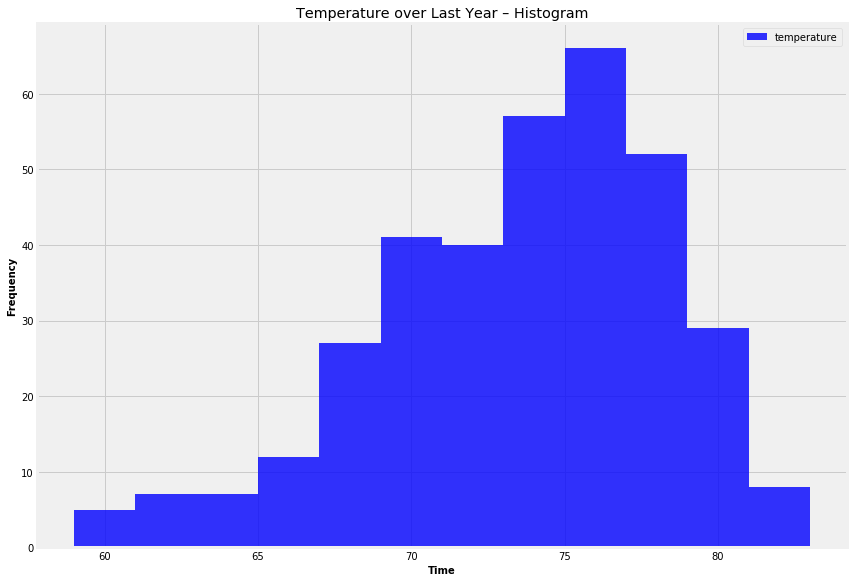

In [16]:
# Plot the results as a histogram
tod_df.plot.hist(bins=12, title="Temperature over Last Year – Histogram", color='blue', alpha=0.8, figsize=(12,8))
plt.tight_layout()
plt.style.use('fivethirtyeight')

plt.xlabel("Time", weight="bold", size=10);
plt.ylabel("Frequency", weight="bold", size=10)

plt.savefig("histogram_temp_12m.png")
plt.show()

In [ ]:
# Step 2 - Climate App
# See app.py